# Chest X-Ray Classification and Disease Localization
To run inference on a random test image, follow these steps:

Upload the Pre-trained Model:
Upload the trained_model_20epochs_1.pth file to Colab:https://drive.google.com/file/d/1tCPDSut7EN-MtlzI-dtfTIbHvYJYUSbk/view?usp=drive_link

Run the Cells Below in Order:

Cell 1: Introduction and Getting the Data

Cell 2: Model Architecture

Cell 3: (optional- GPU)

LOAD MODEL

Cell 4: GRAD CAM (This will calculate and display the heatmap for the image).

The model will predict whether the random test image is "Normal" or "Pneumonia," and the Grad-CAM heatmap will show the areas the model focused on for its prediction.



## **1 Introduction and getting the Data**

X-rays are a crucial diagnostic tool in healthcare. In this project, we will build a deep learning model to classify chest X-ray images as 'Healthy' or 'Sick.' For each case, we will visualize the regions of interest in the image using heatmaps to help the doctor make a diagnostic decision. This will not only evaluate our model's predictive capabilities but also provide interpretability — a critical aspect of medical AI applications.

**imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import numpy as np
from tqdm import tqdm

**loading data and preprocessing / transforms**:

In [ ]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
label2idx = {
    "PNEUMONIA": 0,
    "NORMAL": 1
    }
idx2label = {
    0: "PNEUMONIA",
    1: "NORMAL"
    }

In [ ]:
class Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        for label_dir in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, label_dir)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    if file_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_dir, file_name))
                        self.labels.append(int(label_dir=="NORMAL"))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert from BGR to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # convert from numpy array to PIL Image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = Dataset(root_dir=path+'/chest_xray/train', transform=transform)
val_dataset = Dataset(root_dir=path+'/chest_xray/val', transform=transform)
test_dataset = Dataset(root_dir=path+'/chest_xray/test', transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {"train": train_loader, "test": test_loader, "val": val_loader}

## **2 Explore Dataset and Preprocess**

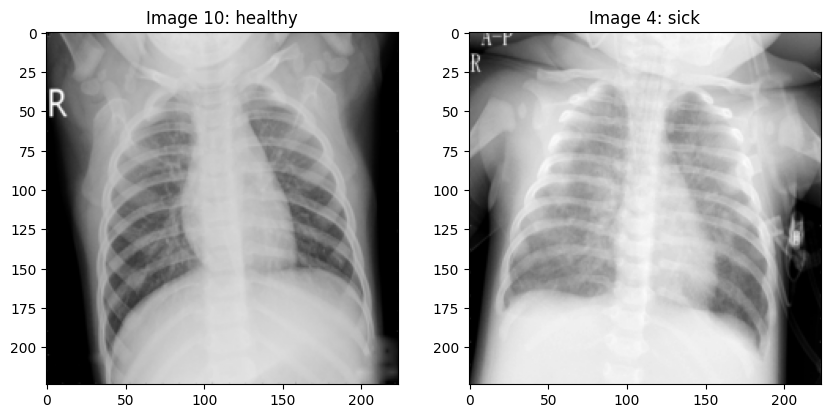

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

i = 10
im =    val_dataset[i][0][0]
label = val_dataset[i][1]

ax[0].imshow(im, cmap="gray")
ax[0].set_title(f'Image {i}: {"healthy" if label else "sick"}')

i = 4
im =    val_dataset[i][0][0]
label = val_dataset[i][1]

ax[1].imshow(im, cmap="gray")
ax[1].set_title(f'Image {i}: {"healthy" if label else "sick"}')

plt.show()

In [ ]:
num_val_images = len(val_dataset)
print(f"Number of images in validation dataset: {num_val_images}")

num_train_images = len(train_dataset)
print(f"Number of images in training dataset: {num_train_images}")


num_test_images = len(test_dataset)
print(f"Number of images in test dataset: {num_test_images}")


Number of images in validation dataset: 16
Number of images in training dataset: 5216
Number of images in test dataset: 624


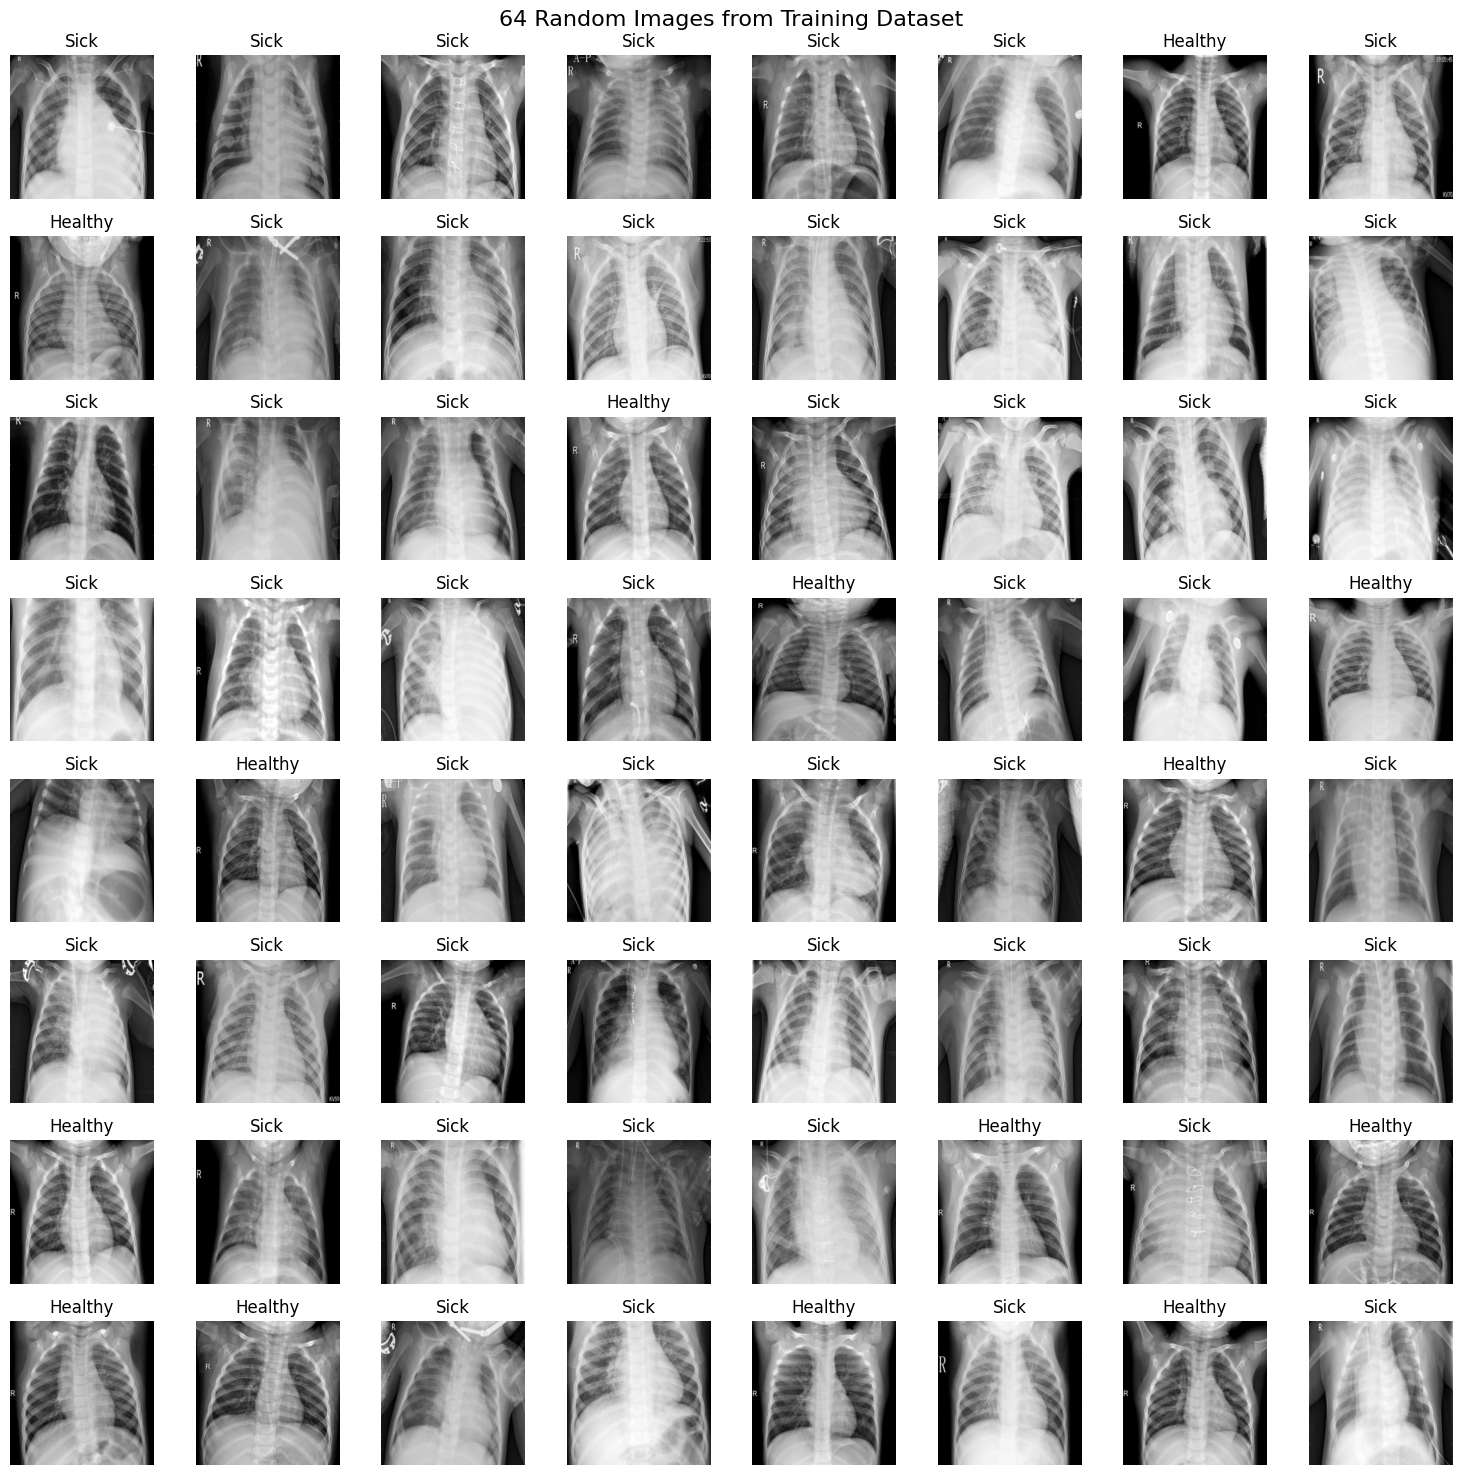

In [ ]:
import matplotlib.pyplot as plt
import random

# Number of images to display
num_images = 64
rows, cols = 8, 8

# Randomly sample indices from the training dataset
random_indices = random.sample(range(len(train_dataset)), num_images)

# Create a grid to display images
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle("64 Random Images from Training Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    # Get random image and label
    img, label = train_dataset[random_indices[i]][0][0], train_dataset[random_indices[i]][1]
    ax.imshow(img, cmap="gray")
    ax.set_title("Healthy" if label else "Sick")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


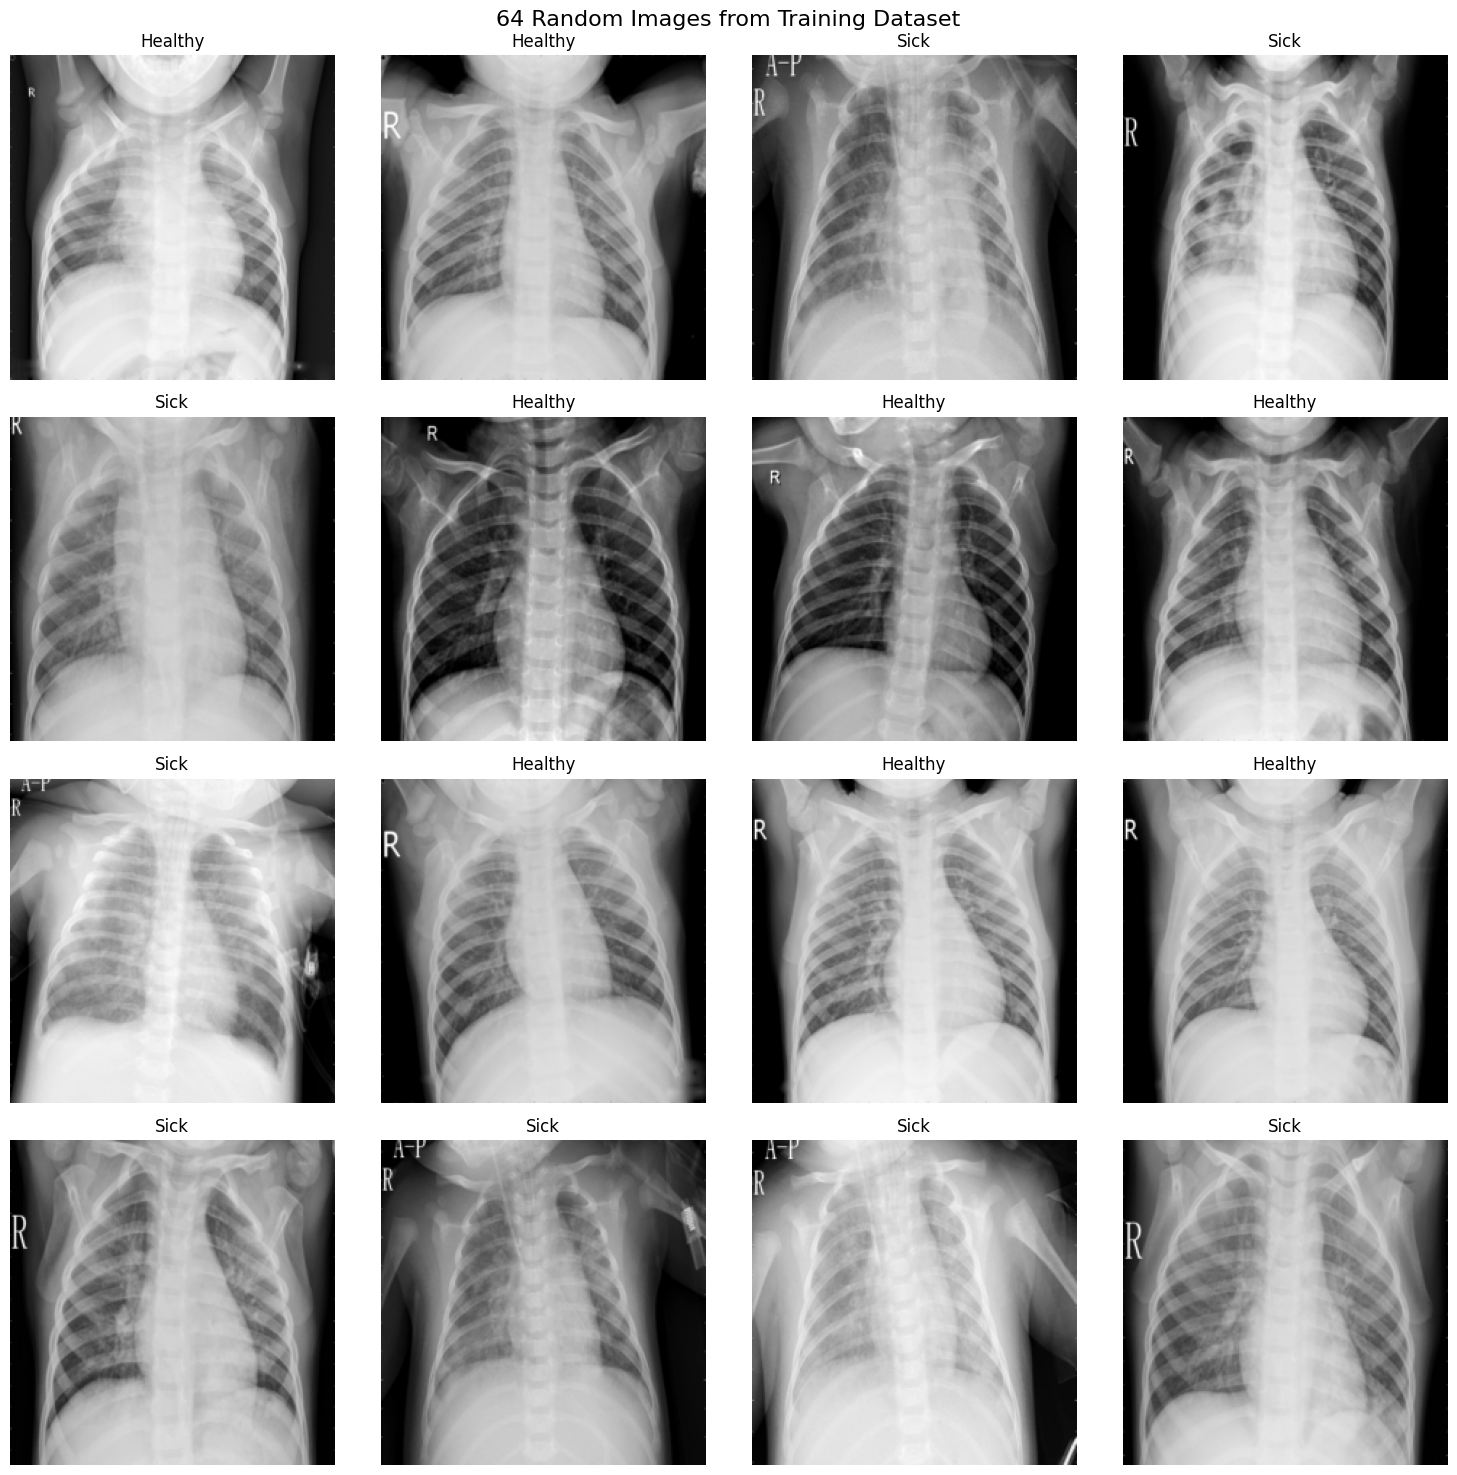

In [ ]:
import matplotlib.pyplot as plt
import random

# Number of images to display
num_images = 16
rows, cols = 4, 4

# Randomly sample indices from the training dataset
random_indices = random.sample(range(len(val_dataset)), num_images)

# Create a grid to display images
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle("64 Random Images from Training Dataset", fontsize=16)

for i, ax in enumerate(axes.flat):
    # Get random image and label
    img, label = val_dataset[random_indices[i]][0][0], val_dataset[random_indices[i]][1]
    ax.imshow(img, cmap="gray")
    ax.set_title("Healthy" if label else "Sick")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

dataset[i][0]    * # Image tensor with shape (1, 224, 224)*

dataset[i][0][0] * # Grayscale data with shape (224, 224) (the only channel)*

dataset[i][1]     *# Label*


In [ ]:
print(im[10:20, 32:40])
print(im.max(), im.min())

tensor([[-0.0824, -0.0980, -0.1294, -0.1608, -0.1373, -0.1529, -0.1529, -0.1294],
        [-0.0902, -0.0824, -0.0902, -0.1216, -0.1373, -0.1294, -0.1216, -0.1059],
        [-0.0824, -0.0745, -0.0667, -0.0902, -0.1294, -0.1216, -0.1137, -0.0902],
        [-0.0902, -0.0745, -0.0745, -0.0745, -0.1216, -0.1216, -0.0980, -0.0902],
        [-0.0824, -0.0980, -0.0824, -0.0824, -0.0902, -0.1137, -0.1137, -0.1294],
        [-0.0902, -0.1294, -0.1137, -0.1059, -0.0980, -0.1137, -0.1608, -0.1843],
        [-0.1137, -0.1373, -0.1373, -0.1137, -0.0980, -0.1137, -0.1529, -0.2078],
        [-0.1529, -0.1373, -0.1373, -0.1216, -0.0902, -0.0745, -0.1216, -0.1922],
        [-0.2078, -0.1608, -0.1451, -0.1137, -0.0980, -0.0745, -0.0824, -0.1294],
        [-0.2235, -0.1529, -0.1137, -0.0902, -0.0667, -0.0745, -0.0588, -0.0980]])
tensor(0.7333) tensor(-1.)


In [ ]:
# ...
# Function to calculate and display label distribution
def check_label_distribution(dataset, dataset_name):
    labels = [dataset[i][1] for i in range(len(dataset))]
    label_counts = torch.bincount(torch.tensor(labels))
    print(f"Label distribution for {dataset_name}:")
    for label, count in enumerate(label_counts):
        print(f"{idx2label[label]}: {count.item()} ({(count.item() / len(dataset)) * 100:.2f}%)")

# Check distribution for each dataset
check_label_distribution(train_dataset, "Training Dataset")
check_label_distribution(val_dataset, "Validation Dataset")
check_label_distribution(test_dataset, "Test Dataset")


Label distribution for Training Dataset:
PNEUMONIA: 3875 (74.29%)
NORMAL: 1341 (25.71%)
Label distribution for Validation Dataset:
PNEUMONIA: 8 (50.00%)
NORMAL: 8 (50.00%)
Label distribution for Test Dataset:
PNEUMONIA: 390 (62.50%)
NORMAL: 234 (37.50%)


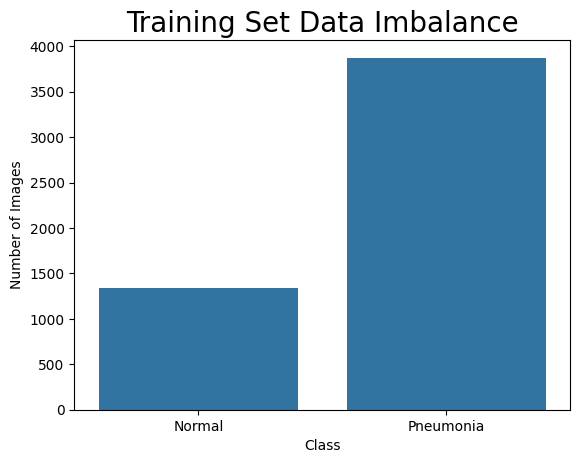

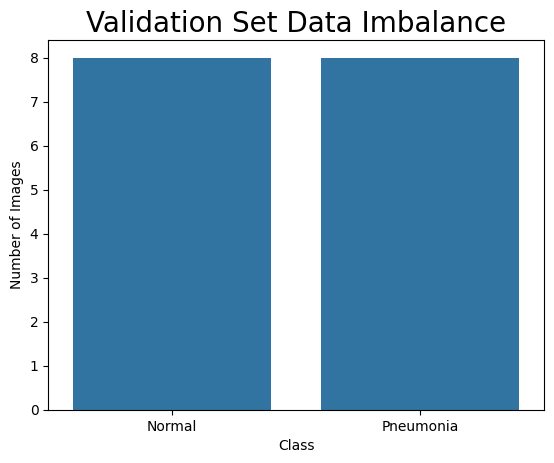

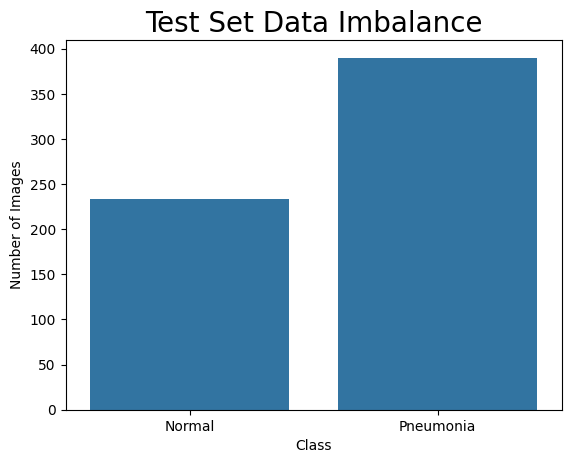

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_dataset_distribution(dataset, title):
    labels = [label for _, label in dataset]

    distribution = pd.DataFrame({
        'Class': ['Normal', 'Pneumonia'],
        'Count': [labels.count(1), labels.count(0)]
    })

    # Plot the distribution
    sns.barplot(data=distribution, x='Class', y='Count')
    plt.title(title, fontsize=20)
    plt.ylabel('Number of Images')
    plt.xlabel('Class')
    plt.show()

plot_dataset_distribution(train_dataset, "Training Set Data Imbalance")
plot_dataset_distribution(val_dataset, "Validation Set Data Imbalance")
plot_dataset_distribution(test_dataset, "Test Set Data Imbalance")

An imbalanced test dataset doesn't impact model learning but balancing it ensures a fair and comprehensive evaluation of the model's performance across all classes. so we will do augmentation to balance train and test:
in Train we are missing 2534 normal images.
in Validation we arent missing any images (equally distributed).

## Augmentation:

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torch

# Define transforms for data augmentation
train_augmentations = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.1)),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Split the dataset by class labels
healthy_indices_train = [i for i, (_, label) in enumerate(train_dataset) if label == 1]  # Normal (Healthy)
sick_indices_train = [i for i, (_, label) in enumerate(train_dataset) if label == 0]    # Pneumonia (Sick)

# Create subsets
healthy_dataset_train = Subset(train_dataset, healthy_indices_train)
sick_dataset_train = Subset(train_dataset, sick_indices_train)

# Augment the training dataset for the "Normal" class
class AugmentedHealthyDataset(Dataset):
    def __init__(self, dataset, transform, augment_count):
        self.dataset = dataset
        self.transform = transform
        self.augment_count = augment_count

    def __len__(self):
        return len(self.dataset) + self.augment_count

    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)
        image, label = self.dataset[original_idx]
        if idx >= len(self.dataset) and self.transform:  # Apply augmentations to extra samples
            image = self.transform(image)
        return image, label

# Augment the Normal class in training
augmented_normal_train = AugmentedHealthyDataset(healthy_dataset_train, train_augmentations, augment_count=2534)
# Combine augmented Normal class and Sick class for training
balanced_train_dataset = ConcatDataset([augmented_normal_train, sick_dataset_train])

train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)

# Print dataset sizes
print(f"Training dataset size (balanced): {len(balanced_train_dataset)}")


Training dataset size (balanced): 7750


Label distribution for Training Dataset:
PNEUMONIA: 3875 (50.00%)
NORMAL: 3875 (50.00%)


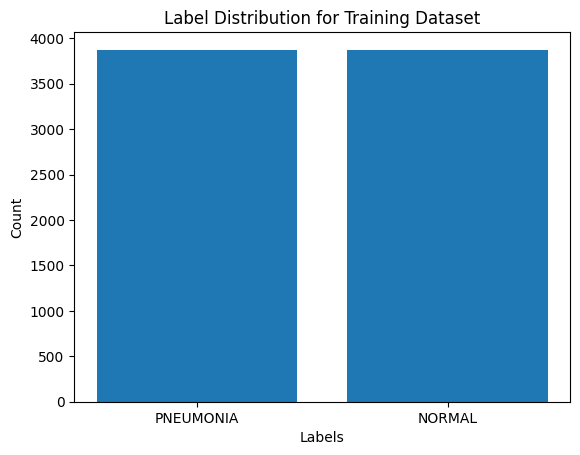

Label distribution for Validation Dataset:
PNEUMONIA: 8 (50.00%)
NORMAL: 8 (50.00%)


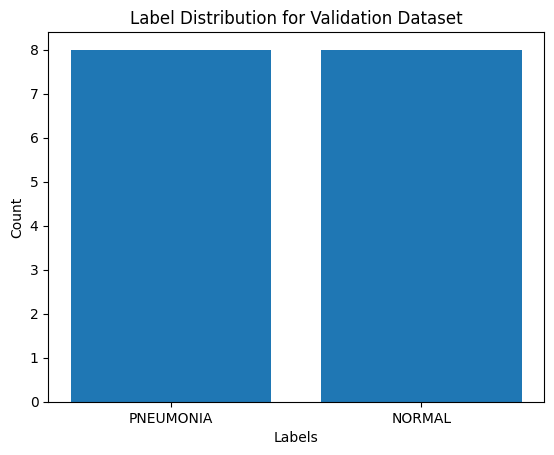

Label distribution for Test Dataset:
PNEUMONIA: 390 (62.50%)
NORMAL: 234 (37.50%)


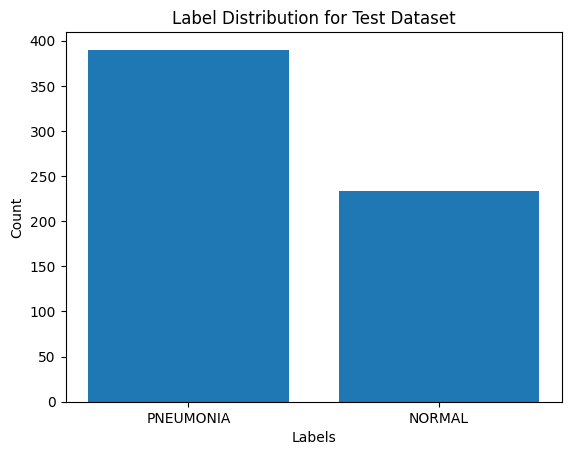

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate and display label distribution
def check_label_distribution(dataset, dataset_name):
    labels = [dataset[i][1] for i in range(len(dataset))]
    label_counts = torch.bincount(torch.tensor(labels))

    print(f"Label distribution for {dataset_name}:")
    for label, count in enumerate(label_counts):
        print(f"{idx2label[label]}: {count.item()} ({(count.item() / len(dataset)) * 100:.2f}%)")

    # Plot the distribution
    plt.bar([idx2label[label] for label in range(len(label_counts))], label_counts.tolist())
    plt.title(f"Label Distribution for {dataset_name}")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()

# Check and visualize distribution for each dataset
check_label_distribution(balanced_train_dataset, "Training Dataset")
check_label_distribution(val_dataset, "Validation Dataset")
check_label_distribution(test_dataset, "Test Dataset")


In [ ]:
from torch.utils.data import random_split

# Define dataset sizes
total_test_size = len(test_dataset)  # Current test dataset size
valid_size = int(0.2 * total_test_size)
test_size = total_test_size - valid_size

# Split test set into validation and test sets
valid_dataset, test_dataset = random_split(test_dataset, [valid_size, test_size])

# Create DataLoaders
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training dataset size: {len(balanced_train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Training dataset size: 7750
Validation dataset size: 124
Test dataset size: 500


Now we got even distribution of both classes.

## **3 Model Architecture**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


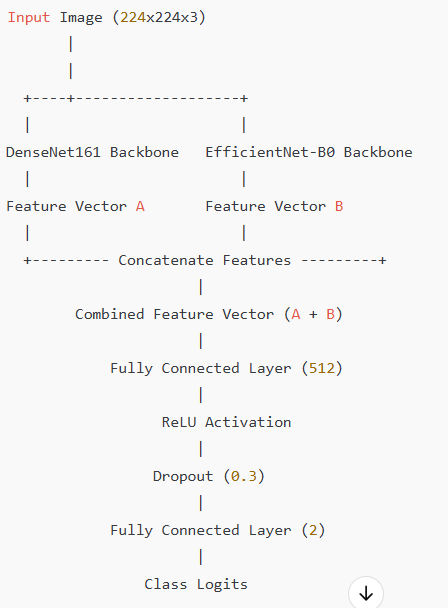

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

''' maybe change to: (suggested to avoid warnings when saving pre trained model)
self.densenet = models.densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)
self.efficientnet = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
'''

class DenseEfficientNet(nn.Module):
    def __init__(self, num_classes=1):
        super(DenseEfficientNet, self).__init__()

        # Load pre-trained DenseNet121
        self.densenet = models.densenet161(pretrained=True)
        dense_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # Remove DenseNet head

        # Load pre-trained EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        eff_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove EfficientNet head

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(dense_features + eff_features, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        dense_features = self.densenet(x)
        efficient_features = self.efficientnet(x)
        combined_features = torch.cat((dense_features, efficient_features), dim=1)
        output = self.classifier(combined_features)
        return output


Also, you might choose different final layers.2 output neurons or just one, here we chose one single neuron output.

once we have set a model, we can test it. of course it is not trained yet but it can make (random) predictions

In [ ]:
i = 3
label = val_dataset[i][1]
im = val_dataset[i][0]
image = im.unsqueeze(dim=0)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Initialize model with 2 classes
num_classes = 2
model = DenseEfficientNet(num_classes=num_classes)
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 178MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be

DenseEfficientNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, 

In [ ]:
prob = model(image.to(device)).softmax(dim=1)
pred = torch.argmax(prob)
# can be done also with unsqueeze(dim=0)
print("prediction:", idx2label[pred.item()], "label:", idx2label[label])

prediction: NORMAL label: PNEUMONIA


### **4 Training**

Choose a loss function and an optimizer.

In [ ]:
import time
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def train_model_with_plot(model, dataloaders, criterion, optimizer, device, num_epochs=25, scheduler=None):
    since = time.time()

    dataset_sizes = {phase: len(dataloaders[phase].dataset) for phase in ['train', 'val']}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Tracking metrics
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float and reshape

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(inputs)  # No need for sigmoid here
                    loss = criterion(logits, labels)

                    # Apply sigmoid and threshold for predictions
                    preds = (torch.sigmoid(logits) > 0.52).float()

                    running_corrects += torch.sum(preds == labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

        print("-" * 30)

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)

    # Plot separate graphs for training and validation
    plot_training_curves(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

    return model

def plot_training_curves(train_loss, train_acc, val_loss, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss (Train and Validation in one graph)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Train Loss", color='blue', linestyle='-')
    plt.plot(epochs, val_loss, label="Validation Loss", color='red', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy (Train and Validation in one graph)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy", color='blue', linestyle='-')
    plt.plot(epochs, val_acc, label="Validation Accuracy", color='red', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 94.3MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may b

Epoch 1/20
Train Loss: 0.1156, Acc: 0.9620
Val Loss: 0.0451, Acc: 1.0000
------------------------------
Epoch 2/20
Train Loss: 0.0272, Acc: 0.9904
Val Loss: 0.1858, Acc: 0.8750
------------------------------
Epoch 3/20
Train Loss: 0.0174, Acc: 0.9946
Val Loss: 0.1884, Acc: 0.8750
------------------------------
Epoch 4/20
Train Loss: 0.0139, Acc: 0.9958
Val Loss: 0.0106, Acc: 1.0000
------------------------------
Epoch 5/20
Train Loss: 0.0182, Acc: 0.9935
Val Loss: 0.2248, Acc: 0.9375
------------------------------
Epoch 6/20
Train Loss: 0.0090, Acc: 0.9975
Val Loss: 0.0687, Acc: 0.9375
------------------------------
Epoch 7/20
Train Loss: 0.0042, Acc: 0.9985
Val Loss: 0.0773, Acc: 0.9375
------------------------------
Epoch 8/20
Train Loss: 0.0017, Acc: 0.9994
Val Loss: 0.0988, Acc: 0.9375
------------------------------
Epoch 9/20
Train Loss: 0.0016, Acc: 0.9996
Val Loss: 0.0304, Acc: 1.0000
------------------------------
Epoch 10/20
Train Loss: 0.0021, Acc: 0.9992
Val Loss: 0.1995, Ac

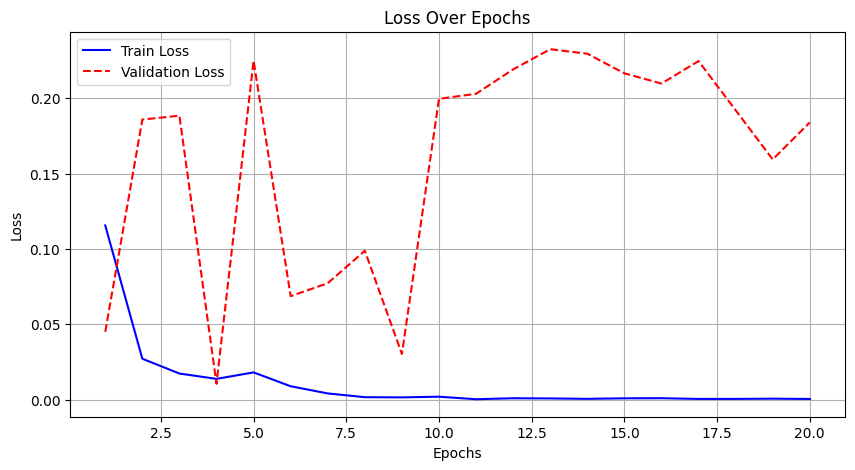

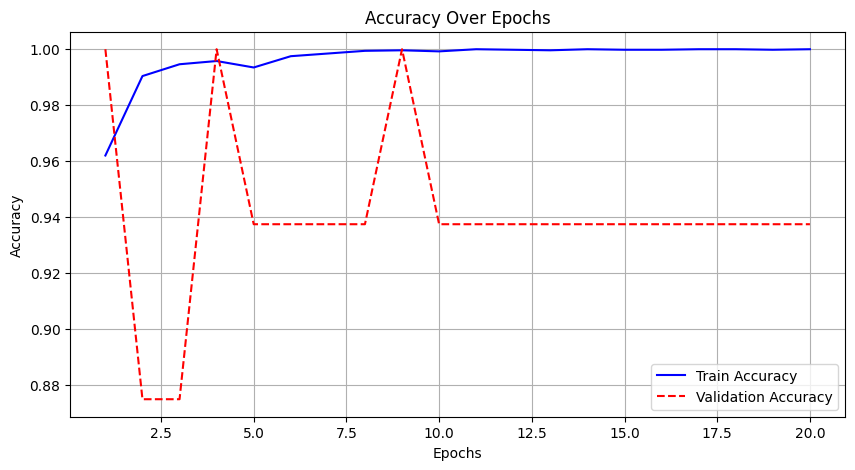

In [ ]:
# Change num_classes from 2 -> 1
model = DenseEfficientNet(num_classes=1)
model.to(device)

# Define optimizer and scheduler
optimizer = torch.optim.Adam([
    {'params': model.densenet.parameters(), 'lr': 0.0001},
    {'params': model.efficientnet.parameters(), 'lr': 0.0001},
    {'params': model.classifier.parameters(), 'lr': 0.002},
])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Change loss function to BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss()

# Train the model
model = train_model_with_plot(model, dataloaders, loss_fn, optimizer, device, num_epochs=20, scheduler=scheduler)


In [ ]:
# Save Model
bestmodel = {'model': DenseEfficientNet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'model.pth')

In [ ]:
!pip install gdown
!gdown 15Cyt38ImnU2QWbAYd5qPZEVxzCF2hVho  # Download the model

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=15Cyt38ImnU2QWbAYd5qPZEVxzCF2hVho

but Gdown can't. Please check connections and permissions.


## LOAD MODEL:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#load model dont forget to define device and load data
model = DenseEfficientNet(num_classes=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/trained_model_20epochs_1.pth', map_location=torch.device("cpu")))
model.eval()
model.to(device)

print("Model loaded successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the 

Model loaded successfully.


## **5 Evaluation**

Use the test set to evaluate the model performance

In [ ]:
import torch
import numpy as np

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    running_corrects = 0

    all_labels = []  # Store true labels
    all_preds = []   # Store predictions

    # Switch to evaluation mode and no gradient tracking
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float and reshape if needed

            logits = model(inputs)  # Get model output (logits)
            preds = torch.sigmoid(logits)  # Apply sigmoid to get probabilities

            preds = (preds > threshold).float()  # Convert probabilities to 0 or 1 based on threshold
            running_corrects += torch.sum(preds == labels)  # Count correct predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate accuracy
    acc = running_corrects.double() / len(dataloader.dataset)
    criterion = torch.nn.BCEWithLogitsLoss()
    loss = criterion(logits, labels) #sending logits bc BCE includes sigmoid ..

    print(f'Threshold = {threshold}')
    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test Loss: {loss:.4f}')
    print(" ")

    return np.array(all_labels), np.array(all_preds)

for th in [0.4,0.5,0.6,0.7]:
  labels, preds = evaluate_model(model, test_loader, device, th)


Threshold = 0.4
Test Accuracy: 0.9183
Test Loss: 0.0002
 
Threshold = 0.5
Test Accuracy: 0.9167
Test Loss: 0.0002
 
Threshold = 0.6
Test Accuracy: 0.9119
Test Loss: 0.0002
 
Threshold = 0.7
Test Accuracy: 0.9006
Test Loss: 0.0002
 


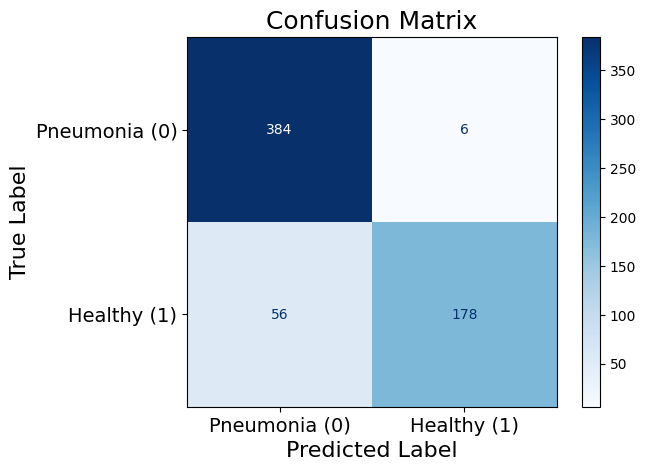

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
th=0.5
# Compute Confusion Matrix
cm = confusion_matrix(labels, preds)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pneumonia (0)', 'Healthy (1)'])
disp.plot(cmap=plt.cm.Blues)

# Customize plot labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)

plt.show()


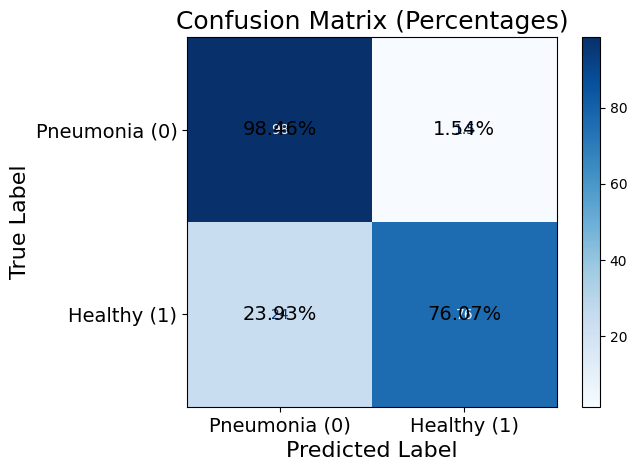

In [ ]:
# with percentage:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
th=0.5
# Compute Confusion Matrix
cm = confusion_matrix(labels, preds)

# Normalize to get percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Pneumonia (0)', 'Healthy (1)'])
disp.plot(cmap=plt.cm.Blues)

# Add percentage text on the matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%', ha='center', va='center', fontsize=14, color='black')

# Customize plot labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix (Percentages)', fontsize=18)

plt.show()


Best Threshold: 0.1976
Best F1-score: 0.8978


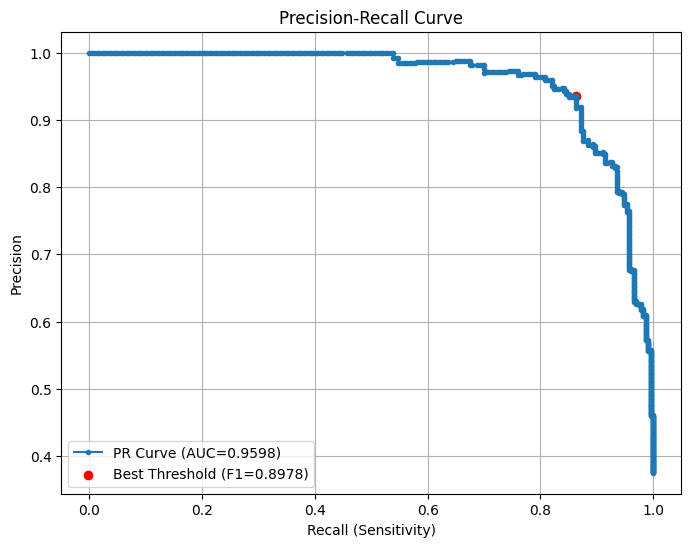

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store true labels and predicted probabilities
y_true = []
y_scores = []

# Set model to evaluation mode
model.eval()

# Loop through the test dataset
with torch.no_grad():  # No gradient calculation needed for inference
    for img, label in test_dataset:
        img = img.unsqueeze(0).to(device)  # Add batch dimension
        label = int(label)  # Convert label to int (0 or 1)

        output = model(img)  # Forward pass
        prob = torch.sigmoid(output).item()  # Sigmoid to get probability

        y_true.append(label)   # Append true label
        y_scores.append(prob)  # Append predicted probability

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Compute Precision, Recall, and AUC
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)  # Compute PR AUC
# Compute F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero

# Find the threshold that maximizes the F1-score
best_index = np.argmax(f1_scores)  # Index of the best threshold
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1-score: {best_f1:.4f}')

# Plot PR Curve with Best Threshold Highlighted
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC={pr_auc:.4f})')
plt.scatter(recall[best_index], precision[best_index], color='red', label=f'Best Threshold (F1={best_f1:.4f})')
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


we thought maybe ploting PR curve for *pneumonia* would be intresting bc the one before was for class 1 which is *healthy* ..

Best Threshold for Pneumonia (Class 0): 0.8024
Best F1-score for Pneumonia: 0.9424


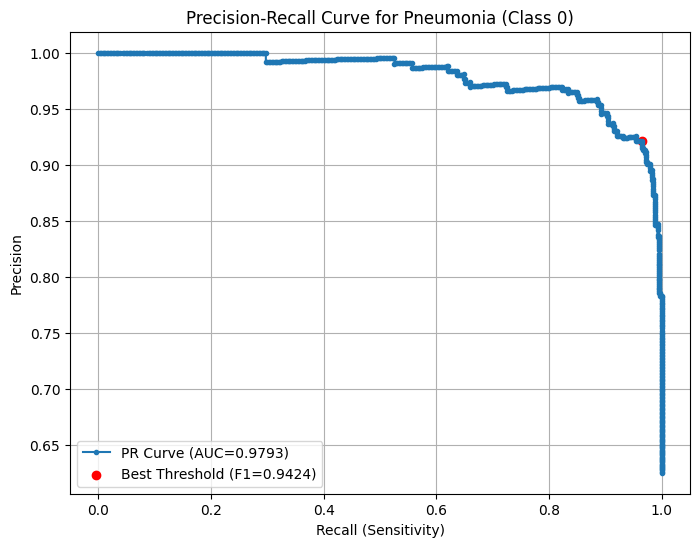

In [ ]:
# Convert y_true so that pneumonia (0) is treated as the positive class
y_true_pneumonia = 1 - y_true  # Convert 0 to 1 (pneumonia is now positive)
y_scores_pneumonia = 1 - y_scores  # Invert probabilities (higher means more pneumonia-like)

# Compute Precision, Recall, and AUC for pneumonia (class 0)
precision, recall, thresholds = precision_recall_curve(y_true_pneumonia, y_scores_pneumonia)
pr_auc = average_precision_score(y_true_pneumonia, y_scores_pneumonia)

# Compute F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero

# Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f'Best Threshold for Pneumonia (Class 0): {best_threshold:.4f}')
print(f'Best F1-score for Pneumonia: {best_f1:.4f}')

# Plot PR Curve for Pneumonia
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC={pr_auc:.4f})')
plt.scatter(recall[best_index], precision[best_index], color='red', label=f'Best Threshold (F1={best_f1:.4f})')
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Pneumonia (Class 0)")
plt.legend()
plt.grid()
plt.show()


## Analyzing evaluation results

we got very low best threshold from the first graph we wanted to see what might be causing this..

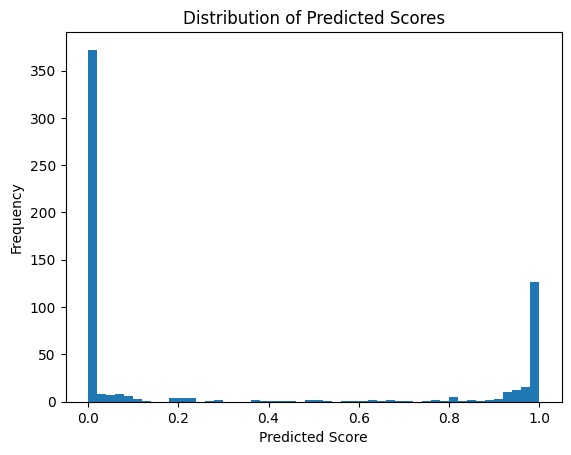

In [ ]:
plt.hist(y_scores, bins=50)
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Scores")
plt.show()

the model is pretty much confident about most predictions..

In [ ]:
import numpy as np
unique, counts = np.unique(y_true, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))


Class distribution: {0: 390, 1: 234}


The model tends to classify as pneumonia more, so maybe thats why lowering the threshold made f1 score higher..

In [ ]:
from sklearn.metrics import f1_score

y_pred_05 = (y_scores >= 0.5).astype(int)
f1_05 = f1_score(y_true, y_pred_05)
print(f"F1-score at threshold 0.5: {f1_05:.4f}")


F1-score at threshold 0.5: 0.8791


Anyways, the f1 score at 0.5 is almost same as at best threshold, so we'll keep it at 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score

y_pred_01976 = (y_scores >= 0.1976).astype(int)
y_pred_05 = (y_scores >= 0.5).astype(int)
y_pred_08 = (y_scores >= 0.8).astype(int)

precision_05 = precision_score(y_true, y_pred_05)
recall_05 = recall_score(y_true, y_pred_05)

precision_01976 = precision_score(y_true, y_pred_01976)
recall_01976 = recall_score(y_true, y_pred_01976)

precision_08 = precision_score(y_true, y_pred_08)
recall_08 = recall_score(y_true, y_pred_08)

print(f"Precision at 0.5:    {precision_05:.4f},    Recall at 0.5: {recall_05:.4f}")
print(f"Precision at 0.1976: {precision_01976:.4f}, Recall at 0.1976: {recall_01976:.4f}")
print(f"Precision at 0.8:    {precision_08:.4f},    Recall at 0.8: {recall_08:.4f}")


Precision at 0.5:    0.9643,    Recall at 0.5: 0.8077
Precision at 0.1976: 0.9349, Recall at 0.1976: 0.8590
Precision at 0.8:    0.9721,    Recall at 0.8: 0.7436


## Metrics

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

# Class 1 (positive class)
accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision_1 = tp / (tp + fp)
recall_1 = tp / (tp + fn)
f1_1 = 2 * ((precision_1 * recall_1) / (precision_1 + recall_1 + 1e-9))  # Avoid division by zero

# Class 0 (negative class)
precision_0 = tn / (tn + fn)
recall_0 = tn / (tn + fp)
f1_0 = 2 * ((precision_0 * recall_0) / (precision_0 + recall_0 + 1e-9))

# Print results
print("Accuracy of the model is {:.2f}".format(accuracy))

# Metrics for Class 1
print("Class 1 - Recall: {:.2f}".format(recall_1))
print("Class 1 - Precision: {:.2f}".format(precision_1))
print("Class 1 - F1 Score: {:.2f}".format(f1_1))

# Metrics for Class 0
print("Class 0 - Recall: {:.2f}".format(recall_0))
print("Class 0 - Precision: {:.2f}".format(precision_0))
print("Class 0 - F1 Score: {:.2f}".format(f1_0))


Accuracy of the model is 0.90
Class 1 - Recall: 0.76
Class 1 - Precision: 0.97
Class 1 - F1 Score: 0.85
Class 0 - Recall: 0.98
Class 0 - Precision: 0.87
Class 0 - F1 Score: 0.93


Prediction visualizations

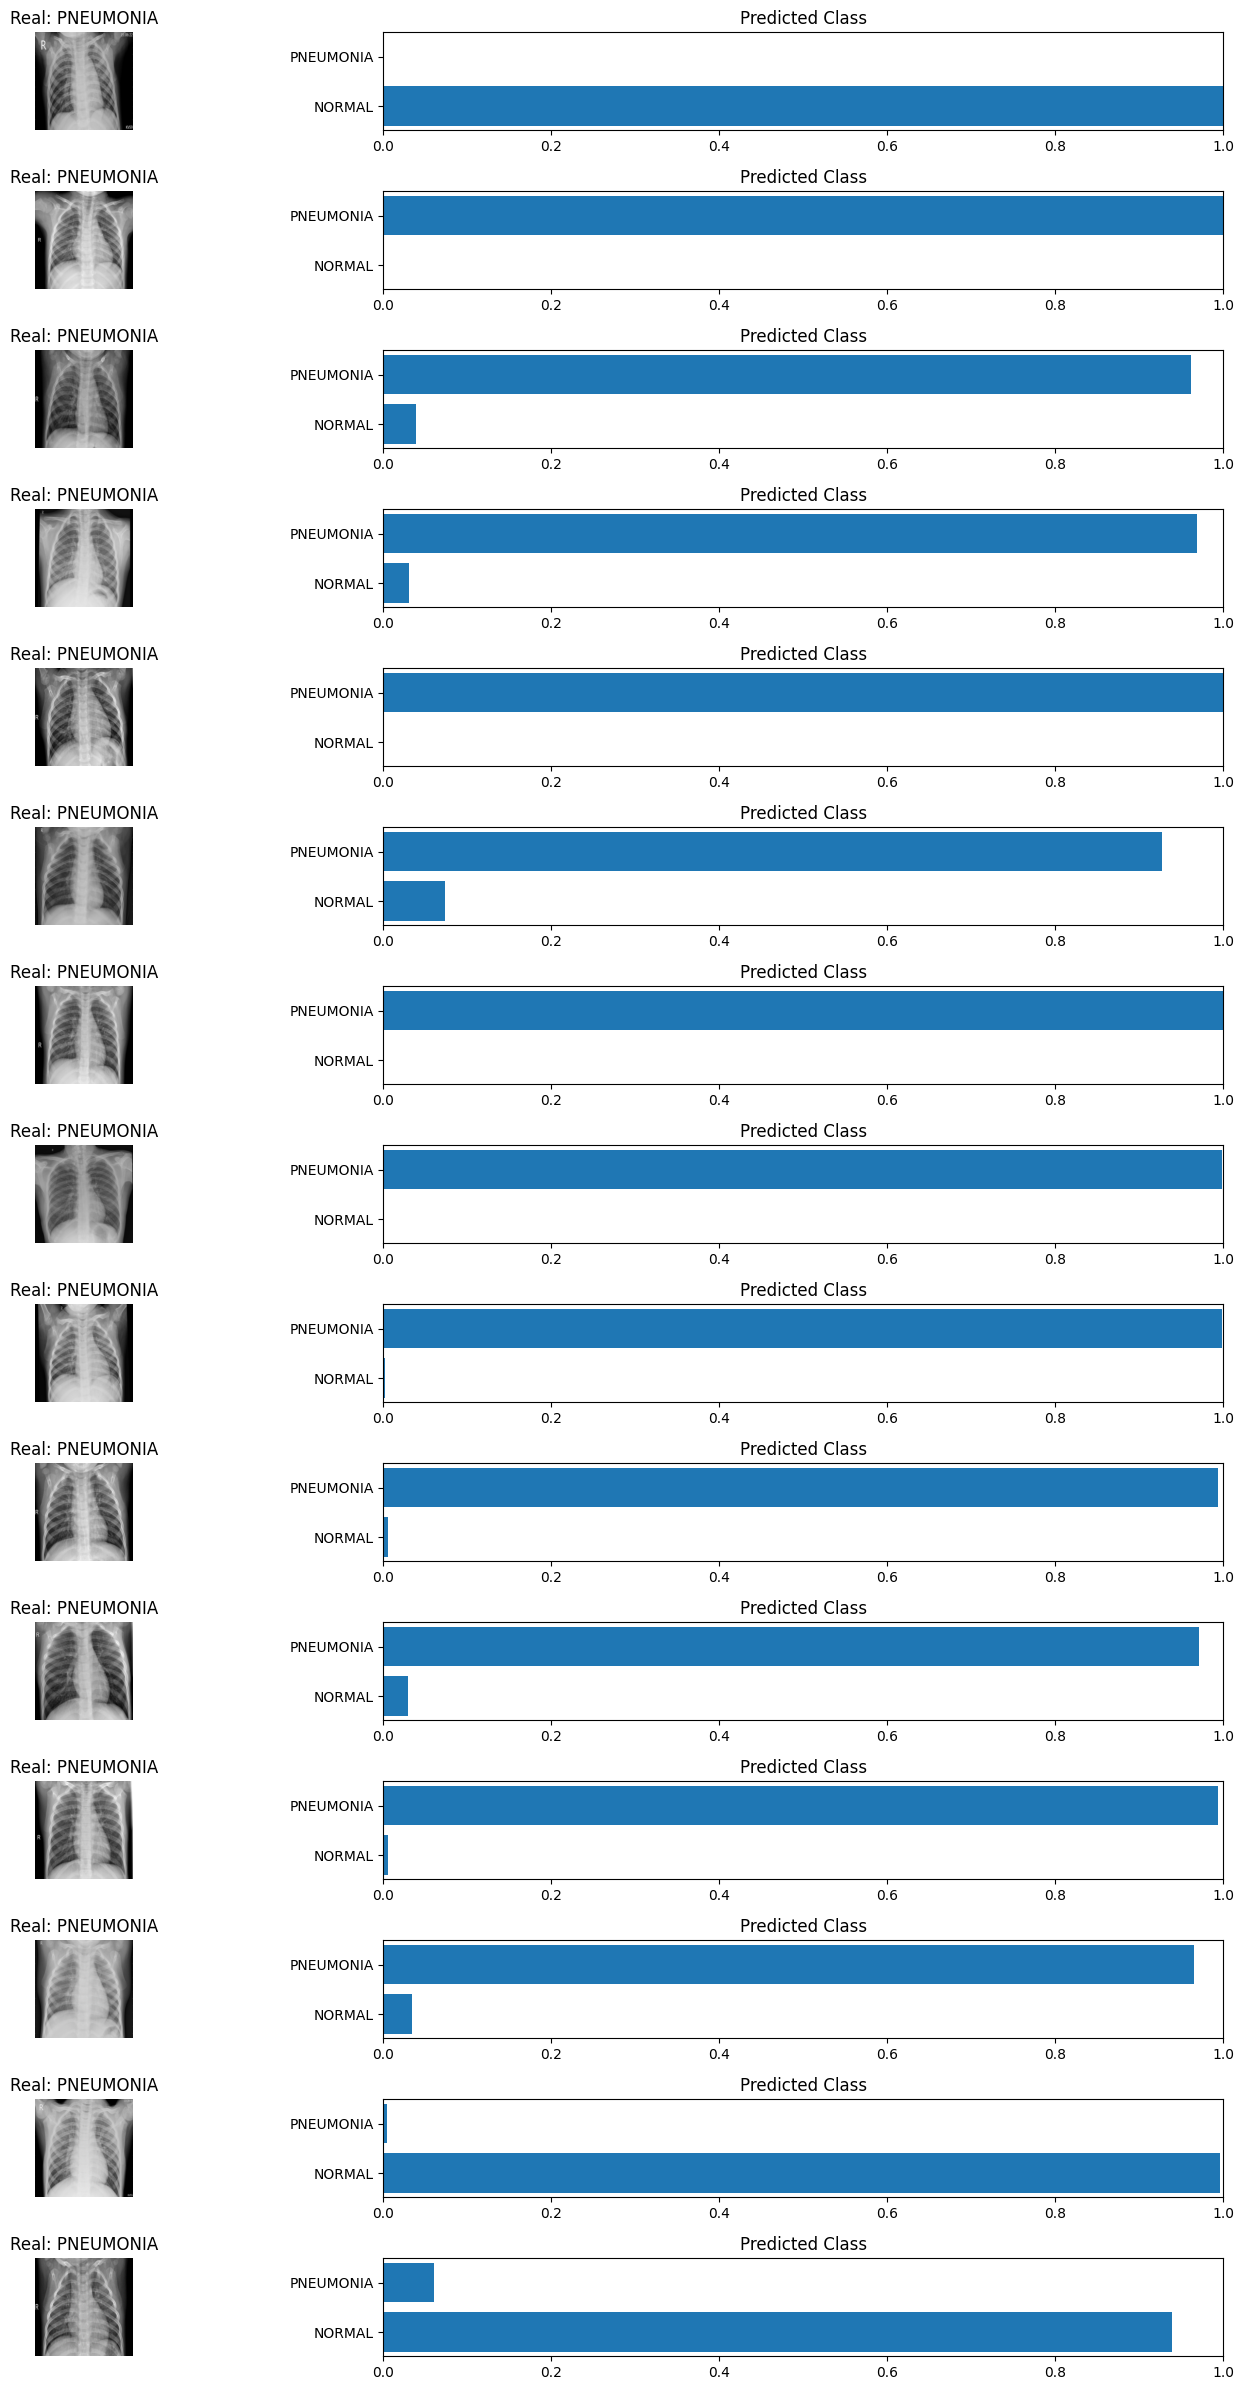

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of test data
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Get one batch
images, labels = images[5:20], labels[5:20]  # Select the first 4 samples
images = images.to(device)

fig, ax = plt.subplots(figsize=(16, 24), ncols=2, nrows=15)

class_names = ["NORMAL", "PNEUMONIA"]

with torch.no_grad():
    logits = model(images)  # Get raw logits
    probs = torch.sigmoid(logits).cpu().numpy().squeeze()  # Convert to probabilities

for row in range(15):
    img = images[row].cpu().permute(1, 2, 0)  # Convert tensor to image format
    img = img * 0.5 + 0.5  # Denormalize to range [0,1]
    label = labels[row].item()  # Get actual label

    ax[row][0].imshow(img)
    ax[row][0].set_title(f'Real: {class_names[label]}')
    ax[row][0].axis('off')

    ax[row][1].barh(class_names, [1 - probs[row], probs[row]])
    ax[row][1].set_xlim(0, 1)
    ax[row][1].set_title('Predicted Class')
    ax[row][1].set_yticks([0, 1])
    ax[row][1].set_yticklabels(class_names)

plt.tight_layout()
plt.show()


## **6 GRAD CAM: calculating the heatmap**
Gradient-weighted Class Activation Mapping

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        self.hooks = []

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        self.hooks = []
        def hook_fn(module, input, output):
            self.activations = output
            output.register_hook(self.save_gradient)

        # Ensure the target layer exists and register the hook correctly
        flag =False
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                self.hooks.append(module.register_forward_hook(hook_fn))
                print("   found layer!! ")
                flag = True
        if not flag:
            raise ValueError(f"Target layer '{self.target_layer_name}' not found in the model.")

        output = self.model(x)
        return output

    def generate_cam(self, class_idx):
        gradients = self.gradients
        activations = self.activations

        # Check if gradients are available before calculating mean
        if gradients is None:
            raise ValueError("Gradients are not available. Make sure to call 'forward' before 'generate_cam'.")

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        for i in range(len(pooled_gradients)):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap = heatmap - torch.min(heatmap)
        heatmap = heatmap / torch.max(heatmap)
        heatmap = heatmap.cpu().detach().numpy()

        return heatmap

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
def get_sample_image(dataset, i):
    return dataset[i][0].reshape([1,3,224,224]), dataset[i][1]

In [ ]:
def show_heatmap_on_image(heatmap, original_image, a):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_LINEAR)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = np.concatenate([heatmap, heatmap, heatmap], axis=-1)
    heatmap = plt.cm.jet(heatmap)[..., :3]

    original_image = np.array(original_image.resize((224, 224)))
    superimposed_img = heatmap[:,:, 0] * a + original_image / 255.0
    m = superimposed_img.max()
    superimposed_img = superimposed_img / m

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(superimposed_img)
    plt.axis('off')
    ax[1].imshow(original_image, cmap="gray")
    plt.show()

def visualize_gradcam(image, model, grad_cam, target_layer_name='layer4'):
    model.eval()
    image = torch.tensor(image, requires_grad=True).to(device)
    output = grad_cam.forward(image)

    '''probability = torch.sigmoid(output).item()   # Sigmoid output (probability of the positive class)
    threshold = 0.5  # You can set your custom threshold here (e.g., 0.5 or higher)
    pred = 1 if probability > threshold else 0

    print("confidence:", probability)
    print("predict:", ["Healthy", "Sick"][pred])'''

     # Compute probability using sigmoid
    # probability = torch.sigmoid(output).item()
    temperature = 2.0  # Adjust as needed
    probability = torch.sigmoid(output / temperature).item()

    # Determine prediction: "Healthy" if prob > 0.5, otherwise "Pneumonia"
    pred_class = 1 if probability > 0.5 else 0
    confidence = probability if pred_class == 1 else 1 - probability

    print(f"Confidence: {confidence:.2f}")
    print(f"Prediction: {['Pneumonia', 'Healthy'][pred_class]}")

    model.zero_grad()

    # Since we are using sigmoid, just backpropagate the positive class (i.e., index 1)
    output.backward()  # Gradients for class 1 are automatically computed

    heatmap = grad_cam.generate_cam(pred_class) # heatmap = grad_cam.generate_cam(pred)  # Use the predicted class (0 or 1) so we see what areas made the model decide the predicted class
    grad_cam.remove_hooks()

    image = transforms.ToPILImage()(image.squeeze())

    show_heatmap_on_image(heatmap, image, a=0.4)


label: Pneumonia
   found layer!! 


<ipython-input-40-3b8584f6c4ab>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True).to(device)


Confidence: 1.00
Prediction: Pneumonia


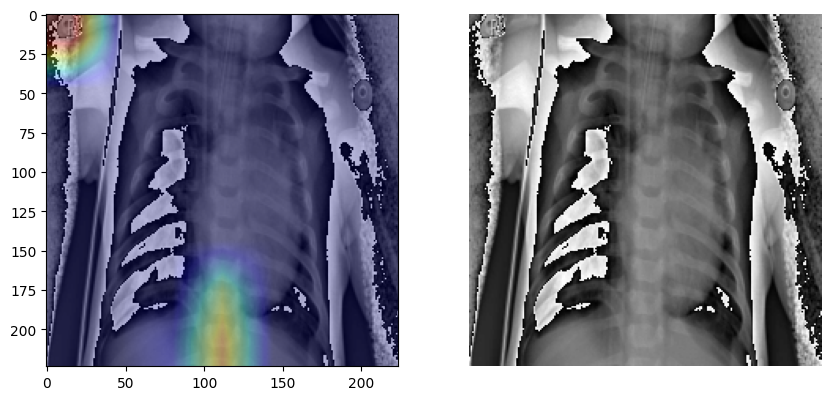

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
i = np.random.randint(0, len(test_dataset))
grad_cam = GradCAM(model, target_layer_name='efficientnet.features.8.1')#'efficientnet.features.5.2.block.3') #'efficientnet.features.7.0.block.3.1')
sample_image, sample_label = get_sample_image(test_dataset, i)
# sample_image, sample_label = get_sample_image(), 0
print("label:", ["Pneumonia", "Healthy"][sample_label])
visualize_gradcam(sample_image, model, grad_cam)

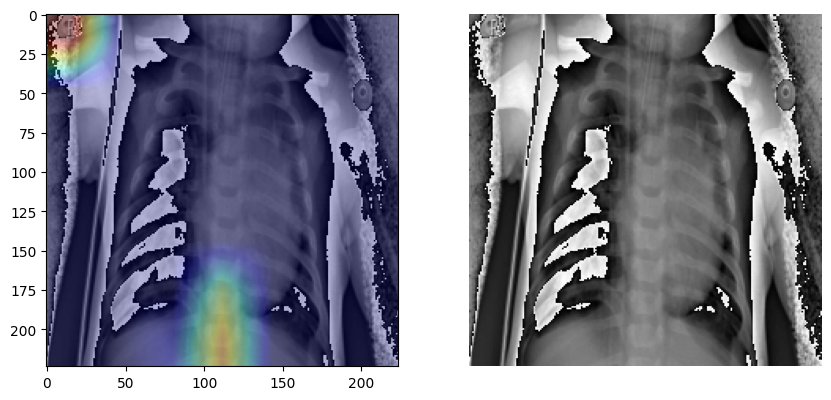

In [ ]:
# Example: Extracting specific layer names
layer_names = [name for name, _ in model.named_modules()]
print(layer_names)


['', 'densenet', 'densenet.features', 'densenet.features.conv0', 'densenet.features.norm0', 'densenet.features.relu0', 'densenet.features.pool0', 'densenet.features.denseblock1', 'densenet.features.denseblock1.denselayer1', 'densenet.features.denseblock1.denselayer1.norm1', 'densenet.features.denseblock1.denselayer1.relu1', 'densenet.features.denseblock1.denselayer1.conv1', 'densenet.features.denseblock1.denselayer1.norm2', 'densenet.features.denseblock1.denselayer1.relu2', 'densenet.features.denseblock1.denselayer1.conv2', 'densenet.features.denseblock1.denselayer2', 'densenet.features.denseblock1.denselayer2.norm1', 'densenet.features.denseblock1.denselayer2.relu1', 'densenet.features.denseblock1.denselayer2.conv1', 'densenet.features.denseblock1.denselayer2.norm2', 'densenet.features.denseblock1.denselayer2.relu2', 'densenet.features.denseblock1.denselayer2.conv2', 'densenet.features.denseblock1.denselayer3', 'densenet.features.denseblock1.denselayer3.norm1', 'densenet.features.dens

In [ ]:
# Print out the names of all layers in the model
for name, module in model.named_modules():
    print(name)


You are welcome to add a function to upload a file from your local device and run the GradCAM functions(so inference is not on test data)

## **7 Application: the final product**

In [ ]:
# (Main functions to run heatmap from model's predictions in a flask file..)

# Define image preprocessing
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


# Main processing function
def process_image(image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Preprocess input image
    image_tensor = preprocess_image(image).to(device)
    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer_name='efficientnet.features.7.0.block.3.1')

    # Run forward pass & get prediction
    output = grad_cam.forward(image_tensor)
    print("Raw logits:", output.item())
    probability = torch.sigmoid(output).item()
    print(f"probability:{probability}")
    pred_class = 1 if probability > 0.5 else 0
    confidence = probability if pred_class == 1 else 1 - probability
    diagnosis = "Healthy" if pred_class == 1 else "Pneumonia"

    # Generate GradCAM heatmap
    model.zero_grad()
    output.backward()  # Compute gradients
    heatmap = grad_cam.generate_cam(pred_class)
    grad_cam.remove_hooks()

    # Convert original image to NumPy
    original_image = np.array(image.resize((224, 224)))

    # Overlay heatmap on the image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_LINEAR)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)

    # Encode the image to return as response
    _, buffer = cv2.imencode('.png', superimposed_img)
    base64_image = base64.b64encode(buffer).decode('utf-8')

    return base64_image, f"{diagnosis} (Confidence: {confidence:.2f})"
